In [ ]:
TROFIMOV_BBMO-01-24

In [29]:
# Установка необходимых пакетов
!pip install adversarial-robustness-toolbox tensorflow matplotlib

# Импортирование необходимых библиотек
import numpy as np  # Библиотека для работы с массивами и матрицами
import tensorflow as tf  # Библиотека для машинного обучения и глубокого обучения
import matplotlib.pyplot as plt  # Библиотека для визуализации данных
from tensorflow.keras.datasets import mnist  # Импортирование MNIST датасета из Keras
from tensorflow.keras.models import Sequential  # Импортирование класса Sequential для создания моделей
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D  # Импортирование слоев для построения нейронной сети
from tensorflow.keras.utils import to_categorical  # Утилита для преобразования меток в категориальный формат
from tensorflow import keras  # Импортирование Keras для работы с моделями
from art.estimators.classification import KerasClassifier  # Импортирование KerasClassifier из ART для работы с Keras моделями
from art.attacks.evasion import FastGradientMethod  # Импортирование метода FGSM для создания состязательных примеров
from art.utils import load_mnist  # Утилита для загрузки MNIST датасета
from art.estimators.classification import TensorFlowV2Classifier  # Импортирование TensorFlowV2Classifier для работы с TensorFlow 2.x
from art.attacks.evasion import FastGradientMethod  # Повторный импорт метода FGSM (можно удалить дублирование)


Загружаем набор данных MNIST, который содержит изображения рукописных цифр и соответствующие метки классов.
Функция load_data() возвращает два кортежа: один для обучающего набора данных и один для тестового

x_train: массив изображений (60,000 изображений размером 28x28 пикселей), которые будут использоваться для обучения модели.

y_train: массив меток (60,000 меток), соответствующих цифрам на изображениях в x_train. Метки представляют собой целые числа от 0 до 9.

x_test: массив изображений (10,000 изображений размером 28x28 пикселей), которые будут использоваться для тестирования модели.

y_test: массив меток (10,000 меток), соответствующих цифрам на изображениях в x_test.

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train.reshape(-1, 28, 28, 1):
Этот код изменяет форму массива x_train, который изначально имеет размерность (60000, 28, 28), на (60000, 28, 28, 1).

Здесь -1 позволяет NumPy автоматически вычислить размер первого измерения (количество изображений), а 1 добавляет дополнительное измерение для канала (в данном случае, это канал для оттенков серого, так как изображения черно-белые).

astype('float32'): преобразует данные в тип float32, что является стандартом для работы с нейронными сетями, так как это позволяет ускорить вычисления и уменьшить использование памяти.

/ 255.0: нормализует значения пикселей, которые изначально находятся в диапазоне от 0 до 255, к диапазону от 0 до 1. Это помогает улучшить сходимость модели во время обучения.

to_categorical(y_train, 10): преобразует метки классов (например, 0, 1, 2, ..., 9) в категориальный формат (one-hot encoding). Это означает, что каждая метка будет представлена в виде вектора, где индекс, соответствующий классу, будет равен 1, а остальные индексы будут равны 0. Например, метка 3 будет представлена как [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

В наборе данных MNIST содержится 10 классов, соответствующих цифрам от 0 до 9. Каждая метка в y_train представляет собой целое число, указывающее на класс (например, 0 для цифры "0", 1 для "1" и так далее до 9).


In [31]:
# Изменение формы обучающего набора данных
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# Изменение формы тестового набора данных
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Преобразование меток классов в категориальный формат для многоклассовой классификации
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


Создание CNN (сверточной нейронной сети) модели

Сверточный слой (Conv2D):

Извлекает признаки из изображений

32 фильтра размером 3x3

Функция активации ReLU для нелинейности

Слой подвыборки (MaxPooling2D):

Уменьшает пространственные размерности

Помогает уменьшить вычислительную сложность

Сохраняет наиболее важные признаки

Flatten слой:

Преобразует многомерный тензор в одномерный вектор

Подготавливает данные для полносвязных слоев

Полносвязные слои (Dense):

Первый слой с 64 нейронами для дополнительной обработки признаков

Выходной слой с 10 нейронами (по количеству цифр)

Softmax активация для получения вероятностей классов

Компиляция модели

Оптимизатор Adam: адаптивный метод оптимизации

Функция потерь categorical_crossentropy: для многоклассовой классификации

Метрика accuracy: измерение точности классификации

Этот код создает простую, но эффективную CNN модель для распознавания

рукописных цифр из набора MNIST.

In [33]:
def create_model():
    # Создание последовательной модели с несколькими слоями
    model = Sequential([
        # Первый сверточный слой:
        # - 32 фильтра размером 3x3
        # - функция активации ReLU
        # - входная форма изображения 28x28x1 (черно-белое изображение)
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),

        # Слой максимальной pooling для уменьшения пространственных размерностей
        # Уменьшает размер изображения в 2 раза
        MaxPooling2D((2, 2)),

        # Преобразование многомерного тензора в одномерный вектор
        Flatten(),

        # Полносвязный слой с 64 нейронами и ReLU активацией
        # Извлекает признаки для классификации
        Dense(64, activation='relu'),

        # Выходной слой с 10 нейронами (по количеству цифр)
        # Softmax для получения вероятностей классов
        Dense(10, activation='softmax')
    ])

    # Компиляция модели с параметрами обучения:
    # - оптимизатор Adam
    # - функция потерь для многоклассовой классификации
    # - метрика точности
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # Возврат скомпилированной модели
    return model


In [34]:
# Обучение модели
model = create_model()  # Создание экземпляра модели, используя функцию create_model()

# Обучение модели на обучающем наборе данных
history = model.fit(x_train, y_train,
                   epochs=3,  # Количество эпох (полных проходов по обучающим данным)
                   batch_size=128,  # Размер пакета (количество образцов, обрабатываемых одновременно)
                   validation_split=0.1,  # Доля данных, используемая для валидации (10% от обучающего набора)
                   verbose=1)  # Уровень вывода информации о процессе обучения (1 - выводить прогресс)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8481 - loss: 0.5523 - val_accuracy: 0.9720 - val_loss: 0.1017
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9729 - loss: 0.0933 - val_accuracy: 0.9820 - val_loss: 0.0689
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.9822 - loss: 0.0613 - val_accuracy: 0.9845 - val_loss: 0.0540


Классификатор позволяет применять различные атаки и методы защиты к модели

In [35]:
# Создание классификатора ART для модели TensorFlow
art_classifier = TensorFlowV2Classifier(
    model=model,  # Передача ранее созданной модели TensorFlow
    nb_classes=10,  # Количество классов (в данном случае 10, так как мы классифицируем цифры от 0 до 9)
    input_shape=(28, 28, 1),  # Форма входных данных (изображения 28x28 пикселей с 1 цветовым каналом)
    clip_values=(0, 1),  # Значения, на которые будут ограничены пиксели (в данном случае от 0 до 1 после нормализации)
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Функция потерь для многоклассовой классификации
    channels_first=False  # Указывает, что порядок каналов в данных - "последовательный", а не "первый"
)


Создаем экземпляр атаки FGSM

estimator=art_classifier: передает ранее созданный классификатор ART, который будет использоваться для генерации состязательных примеров.

eps=0.1: задает величину искажения, которое будет добавлено к входным данным. Это значение определяет, насколько сильно будут изменены пиксели изображений для создания состязательных примеров. Чем больше значение eps, тем более агрессивной будет атака.

In [53]:
# Создание атаки FGSM с использованием классификатора ART
attack_fgsm = FastGradientMethod(estimator=art_classifier, eps=0.1)

# Генерация состязательных примеров на тестовом наборе данных
x_test_adv = attack_fgsm.generate(x_test)


Состязательные примеры (или adversarial examples) — это специально измененные входные данные

In [37]:

loss_adv, adv_acc = model.evaluate(x_test_adv, y_test, verbose=0)
#Значение 0 означает, что не будет выводиться никакой информации во время оценки.
print(f"Точность на adversarial данных: {adv_acc:.4f}")

Точность на adversarial данных: 0.6050


Функция предназначена для визуализации изображений и их заголовков. Она принимает массив изображений, заголовки, количество изображений для отображения и цветовую карту.

Внутри функции создается фигура, и для каждого изображения создается подграфик, где изображение отображается с соответствующим заголовком.

Выбор случайных примеров:
sample_idx = np.random.choice(len(x_test_adv), 5): выбирает 5 случайных индексов из тестового набора состязательных изображений для дальнейшей визуализации.

Предсказания модели:
clean_preds и adv_preds: вычисляют предсказания модели для оригинальных и состязательных изображений соответственно, используя метод predict. np.argmax используется для получения индекса класса с наибольшей вероятностью.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Примеры оригинальных изображений:


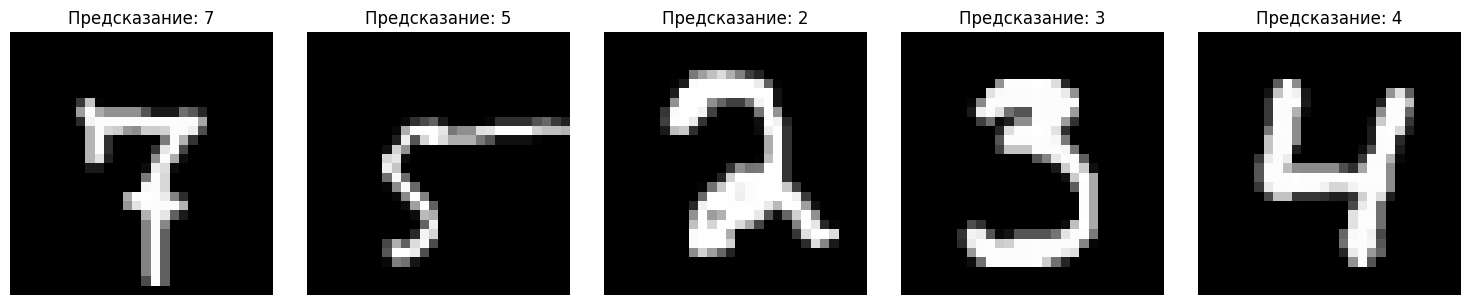


Примеры adversarial изображений:


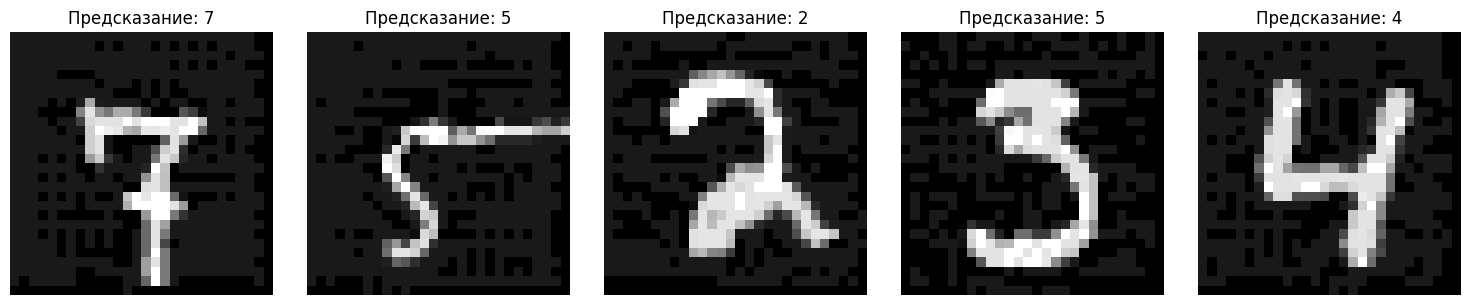


Визуализация возмущений:


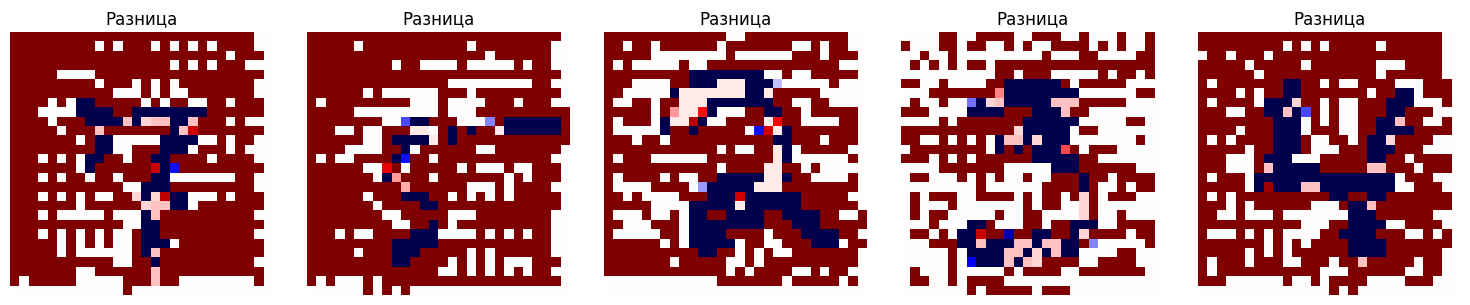

In [43]:
# 8. Визуализация результатов
def plot_samples(images, titles, n=5, cmap='gray'):
    # Создание фигуры для отображения изображений
    plt.figure(figsize=(15, 3))
    for i in range(n):
        # Создание подграфика для каждого изображения
        plt.subplot(1, n, i+1)
        # Отображение изображения с заданной цветовой картой
        plt.imshow(images[i].reshape(28, 28), cmap=cmap)
        # Установка заголовка для подграфика
        plt.title(titles[i])
        # Отключение осей для более чистого отображения
        plt.axis('off')
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.show()  # Отображение фигуры

# Выбираем случайные примеры из тестового набора состязательных изображений
sample_idx = np.random.choice(len(x_test_adv), 5)

# Предсказания модели на оригинальных изображениях
clean_preds = np.argmax(model.predict(x_test[sample_idx]), axis=1)
# Предсказания модели на состязательных изображениях
adv_preds = np.argmax(model.predict(x_test_adv[sample_idx]), axis=1)

# Вывод оригинальных изображений и их предсказаний
print("\nПримеры оригинальных изображений:")
plot_samples(x_test[sample_idx], [f"Предсказание: {p}" for p in clean_preds])

# Вывод состязательных изображений и их предсказаний
print("\nПримеры adversarial изображений:")
plot_samples(x_test_adv[sample_idx], [f"Предсказание: {p}" for p in adv_preds])

# Визуализация разницы между оригинальными и состязательными изображениями
print("\nВизуализация возмущений:")
plot_samples(x_test_adv[sample_idx] - x_test[sample_idx],
            ["Разница"]*5,
            cmap='seismic')


x_train_adv = attack_fgsm.generate(x_train[:5000]): создает состязательные примеры для первых 5000 изображений из обучающего набора данных с использованием метода FGSM. Это позволяет создать искаженные версии оригинальных изображений, которые будут использоваться для обучения модели.

Объединение данных:
x_train_mixed = np.concatenate([x_train[:5000], x_train_adv]): объединяет оригинальные изображения и их состязательные версии в один набор данных для обучения.

y_train_mixed = np.concatenate([y_train[:5000], y_train[:5000]]): объединяет метки классов для оригинальных и состязательных изображений. Поскольку метки для состязательных примеров такие же, как и для оригинальных, они дублируются.

Создание новой модели:
model_robust = create_model(): создает новую модель, которая будет обучаться на смешанном наборе данных.

Обучение модели:
history_robust = model_robust.fit(...): обучает модель на смешанном наборе данных, используя метод fit.

Параметры:
epochs=3: модель будет проходить через весь набор данных 3 раза.
batch_size=128: размер пакета, который будет использоваться для обучения.
validation_split=0.1: 10% данных будет использоваться для валидации, что позволяет отслеживать производительность модели на данных, которые она не видела во время обучения.
verbose=1: выводит информацию о процессе обучения.

In [44]:
#Adversarial Training (защита)
print("\nAdversarial Training...")

# Генерация состязательных примеров для небольшого подмножества обучающих данных (5000 изображений)
x_train_adv = attack_fgsm.generate(x_train[:5000])  # Используем FGSM для создания состязательных примеров

# Объединение оригинальных и состязательных изображений в один набор данных
x_train_mixed = np.concatenate([x_train[:5000], x_train_adv])
# Объединение меток классов для оригинальных и состязательных изображений
y_train_mixed = np.concatenate([y_train[:5000], y_train[:5000]])

# Создание новой модели для обучения
model_robust = create_model()

# Обучение модели на смешанном наборе данных (оригинальные и состязательные примеры)
history_robust = model_robust.fit(x_train_mixed, y_train_mixed,
                                epochs=3,  # Количество эпох обучения
                                batch_size=128,  # Размер пакета для обучения
                                validation_split=0.1,  # Доля данных для валидации (10%)
                                verbose=1)  # Уровень вывода информации о процессе обучения



Adversarial Training...
Epoch 1/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7099 - loss: 1.1911 - val_accuracy: 0.9270 - val_loss: 0.2499
Epoch 2/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9314 - loss: 0.2447 - val_accuracy: 0.9610 - val_loss: 0.1621
Epoch 3/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9598 - loss: 0.1546 - val_accuracy: 0.9770 - val_loss: 0.1014


In [51]:
#Оценка защищенной модели

# Оценка точности оригинальной модели
_, robust_clean_acc = model_robust.evaluate(x_test, y_test, verbose=0)

# Оценка точности защищенной модели
_, robust_adv_acc = model_robust.evaluate(x_test_adv, y_test, verbose=0)

# Вывод сравнения точности
print("\nСравнение точности:")

print(f"Оригинальная модель (adversarial): {adv_acc:.4f}")

print(f"Защищенная модель (adversarial): {robust_adv_acc:.4f}")



Сравнение точности:
Оригинальная модель (adversarial): 0.6050
Защищенная модель (adversarial): 0.9550
